# 2023 JETSCAPE Summer School Hands-on Session (Bayesian Analysis)

Modified from Derek Everett's Jupyter notebook for Band Camp 2020

**Docker Users:** Run the console command `jupyter-notebook --ip 0.0.0.0 --no-browser` and copy-paste the provided link into your browser to run this notebook.

## Goals of this Notebook

In this notebook we will explore topics related to performing **Bayesian inference** (in particular **Bayesian parameter estimation**) using a **Gaussian Process** (GP) emulator for our underlying model.

## Bayesian Inference

**Bayesian Inference** is a statistical methodology which can handle arbitrarily complicated problems of inference. 

Suppose we know some information $D$, for example a set of experimental measurements. 
Now, suppose we want to make an inference about a parameter $\theta$, for example some physical property of system which can not be directly measured. 

Bayes' rule can be written as $$p(\theta|D) = \frac{ p(D|\theta) p(\theta) }{ p(D) },$$ 

where
- $p(\theta|D)$ is our "posterior" for $\theta$ given that $D$ is realized, 

- $p(D|\theta)$ is the "likelihood" of observing $D$ given the parameter $\theta$, 

- $p(\theta)$ is our "prior" belief about $\theta$ before observing $D$, 

- $p(D)$ is the "evidence". 

If we are only interested in $\theta$, then we can use that the evidence is independent of $\theta$ and solve instead the proportionality
$$p(\theta|D) \propto p(D|\theta) p(\theta) .$$ 
This fact will be very useful for Bayesian parameter estimation. 

## Defining our simulator

We see that our likelihood function $p(D|\theta)$ encodes the conditional probability of observing some value of the data given a particular value of the model parameter.

In this notebook, we assume there is a *linear* relationship between model parameter $\theta$ and output variable $y$, and the simulation model is given in `lin_model` (see code below).

Note that we use a linear model in this notebook because it isn't computationally demanding, allowing us to focus on concepts of Bayesian inference and emulation. However, whenever we discuss our model, we should have in mind a realistic physics model can be arbitrarily complex, non-linear and slow.

### Statistical Model Error

Let's add to our linear model statistical (uncorrelated) error on top of every output. 
This will be useful for understanding how any statistical model errors influence our inference problem. 

### Expressing the model
Let $y$ denote the ouput, and $\theta$ the parameter of interest. We can write our linear model by
$$y = m \cdot \theta + b +\epsilon,$$ 
which has a slope $m$, intercept $b$ and statistical error $\epsilon$.

### Let's import some libraries

In [1]:
import numpy as np #useful for math operations
import matplotlib.pyplot as plt #plotting
import seaborn as sns #pretty plots
sns.set()
sns.set_context('talk')

import GPy # Library with Gaussian Processes
from sklearn.preprocessing import StandardScaler #useful for scaling data

import emcee #for performing Markov Chain Monte Carlo
import corner #for plotting the posterior

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


### This function will define our simulator

In [2]:
#noise level controls statistical scatter in our simulator $\epsilon$
noise = 0.01 #amount of statistical scatter in our training calculations
np.random.seed(1)

def lin_model(theta, intercept = 0.12, slope = -0.25, noise = noise):
    """This function will play the role of a 
    realistic physics model. Here it is a linear model 
    with an additional random noise error."""
    
    y = intercept + slope * (theta) # the mean model prediction
    dy = noise * np.random.normal() #the sampled model statistical error
    y += dy #add the model stat. error to the model mean
    y = np.max([0., y]) #suppose our measurement is positive
    return y, np.abs(dy)

lin_model = np.vectorize(lin_model)

## Using a fast Model Emulator for slow simulators 

A realistic physics model, for example, could take hours to run a single event given some value for our parameter. Furthermore, we may need thousands of events to calculate our observable with sufficient statistical precision. 

For computationally demanding models we can employ a fast surrogate which can estimate the interpolation uncertainty.

We use Gaussian process for this purpose in this notebook. Gaussian process is especially useful because they provide non-parametric interpolations (as opposed to a polynomial fit, for example).   

Like any interpolation, we need a sampling of points in our parameter space where we know the **simulator output**. 

So, we first run our simulation on a sampling of points that **fill our parameter space** and call this sample our **design points**.

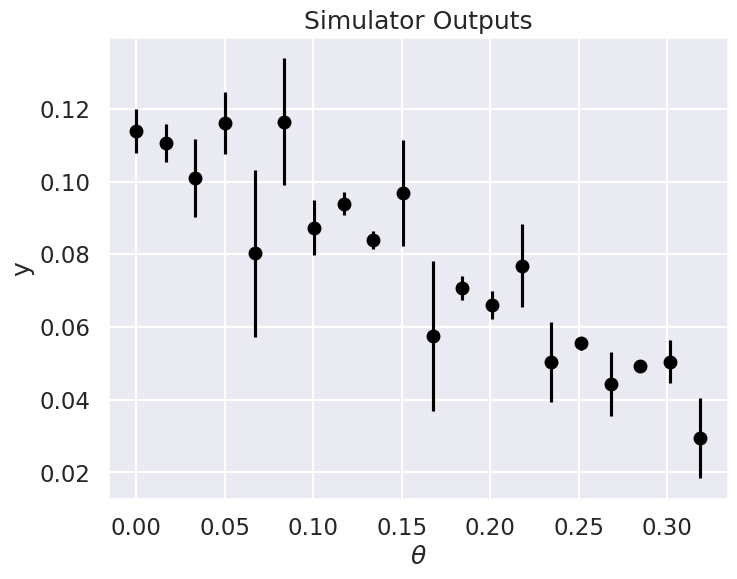

In [3]:
n_design_pts = 20 # this sets the number of design points where we will run our linear model
theta_min = 0. # this defines a minimum value for our parameter
theta_max = 1. / np.pi # this defines a maximum value for our parameter

#this chooses our sample to be a regular grid, which is an efficient sampling in one dimension
#it is reshaped into a 2D array so that we can readily used
#in various libraries
model_X = np.linspace(theta_min, theta_max, n_design_pts).reshape(-1,1)

#these are the outputs of our linear model, assuming that the model has finite statistical error
model_y, model_dy = lin_model(model_X)

#lets plot our simulator outputs
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plt.errorbar(model_X.flatten(), model_y.flatten(), model_dy.flatten(), fmt='o', c='black')
plt.xlabel(r'$\theta$')
plt.ylabel('y')
plt.title('Simulator Outputs')
plt.show()

### Exercises:
1. Does it look like a linear model produced these data?
2. Try playing with the amount of noise (error) in these data.

### Training our Gaussian Process (GP)
We will use a Gaussian process (https://en.wikipedia.org/wiki/Gaussian_process) to interpolate between the design points.

For an intuitive feeling for how they work, play with this widget http://www.tmpl.fi/gp/.
For more details see http://www.gaussianprocess.org/gpml/chapters/RW.pdf.

A Gaussian process is defined with some choice of a **kernel function**. 
Please see this page for a brief explanation of a few popular kernels : https://www.cs.toronto.edu/~duvenaud/cookbook/.

This is a very good visual exploration of Gaussian processes as well as different kernel functions: https://distill.pub/2019/visual-exploration-gaussian-processes/.


We will tell our GP library the kernel function to use, and typically some guidance for the range of the hyperparameters. Then when we call the `optimize()` operation, the library will find the values of hyperparameters that maximize a likelihood function:

$$\log p(y^*|y_{t}, \theta) \propto -\frac{1}{2}y_{t}^{T} \Sigma^{-1}_{y_t} y_{t} - \frac{1}{2} \log |\Sigma_{y_t}|,$$

where $\Sigma_{y_t}$ is the covariance matrix resulting from applying the covariance function to the **training data**. 

### Now we will define and train a GP

We will use a combination of a **Squared Exponential Kernel** and a **White Noise Kernel**.

In [4]:
#this is the 'size' of possible variation of our parameters
ptp = max(model_X) - min(model_X)

#This is our Squared Exponential Kernel
rbf_kern = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=ptp)

#This is a white noise kernel, 
#necessary because our simulator has finite statistical accuracy,
#and therefore statistical scatter in its predictions
white_kern = GPy.kern.White(1, variance=noise)

#The total kernel function is a sum here, 
#but other combinations are possible (products, compositions, ...)
my_kernel = (rbf_kern + white_kern)

As with many machine learning toolkits, out-of-the-box performance is often best when we first scale our outputs to unit range. The 'Standard Scaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is convenient for this purpose.

In [5]:
#first scale our observables 
model_y_copy = model_y.copy()
scaler = StandardScaler(copy=True).fit(model_y_copy)
scaled_model_y = scaler.transform(model_y, copy=True) # the scaled model outputs (zero mean and unit variance)

### Training our GP on the linear model calculations

In [6]:
#define our Gaussian process model, and fit it to the linear model calculations
my_gp = GPy.models.GPRegression(model_X, scaled_model_y, my_kernel)
my_gp.optimize(messages=False)

In [7]:
#take a look at the fitted parameters
print(my_gp)


Name : GP regression
Objective : 16.47187993390405
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  sum.rbf.variance         |    2.6899143966082706  |      +ve      |        
  sum.rbf.lengthscale      |    0.2550668588026888  |      +ve      |        
  sum.white.variance       |  0.009679809328639167  |      +ve      |        
  Gaussian_noise.variance  |    0.1724669278333912  |      +ve      |        


### Constructing an 'emulator'
It's useful to define a method which handles both the scaling of our observables as well as the prediction with the GP. We call this function the **emulator**. 

In [8]:
def emu_predict(theta):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space.
    This map is what we call our 'emulator'. """
    X = theta.reshape(-1, 1)
    scaled_y, scaled_dy2 = my_gp.predict(X, full_cov=False)
    scaled_dy2 = scaled_dy2[:,0] #change shape of the variance
    scaled_dy = np.sqrt(scaled_dy2) #GPy returns the variance, want std. dev.
    y = scaler.inverse_transform(scaled_y).reshape(len(theta)) #scale back to original scale: essentially scaled_y*scaler.scale_+scaler.mean_
    dy = scaled_dy * scaler.scale_
    return y, dy

### Let's check how well our emulator fits the simulator

and if its behavior is sensible/interpretable. 

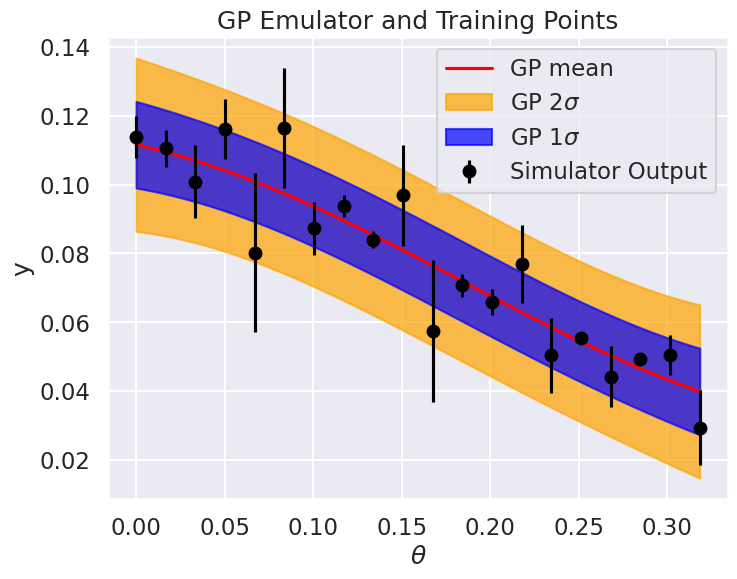

In [9]:
#make a regular grid to plot our emulator predictions
n_plot_pts = 100
gp_X_plot = np.linspace(theta_min, theta_max, n_plot_pts)

#get the GP emulator's predictions of both the mean and std. deviation
gp_y, gp_dy = emu_predict(gp_X_plot)

fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(gp_X_plot, gp_y, color='red', label='GP mean')
plt.fill_between(gp_X_plot, y1 = gp_y - 2.*gp_dy, y2 = gp_y + 2.*gp_dy, 
                 interpolate=True, alpha=0.7, label=r'GP 2$\sigma$', color='orange')
plt.fill_between(gp_X_plot, y1 = gp_y - gp_dy, y2 = gp_y + gp_dy, 
                 interpolate=True, alpha=0.7, label=r'GP 1$\sigma$', color='blue')
plt.errorbar(model_X.flatten(), model_y.flatten(), model_dy.flatten(), fmt='o', c='black', label='Simulator Output')

plt.xlabel(r'$\theta$')
plt.ylabel('y')
plt.title('GP Emulator and Training Points')
plt.legend(loc='upper right')
plt.show()

### Exercises:

1. Examine how increasing/decreasing the number of design points affects the mean and std. dev. of the GP emulator prediction. Does it fit your expectation?

2. Examine how increasing/decreasing the model statistical error affects the mean and std. dev. of the GP emulator prediction. Does it fit your expectation?

3. Examine how changing the distribution of design points affects the mean and std. dev. of the GP emulator prediction (try a design which has regions which are sparsely populated by design points). Does it fit your expectation?


### We expect our emulator to fit the points on which it was trained
...our definition of the GP likelihood function is designed to do just that!

Ultimately, we want to know if we can trust our emulator's predictions for points in parameter space at which it was **not trained**. 

So, let's perform some validations of our GP emulator, using a **novel testing set** of model calculations.

In [10]:
#this defines a new set of points in parameter space where we will run our linear model
n_test_pts = 100
model_X_test = np.random.uniform(theta_min, theta_max, n_test_pts).reshape(-1,1)
#get the linear model outputs for these new points
model_y_test, model_dy_test = lin_model(model_X_test)

#Now use the emulator trained only on the **original design points** to predict
#outputs on the **new testing set**
gp_y_test, gp_dy_test = emu_predict(model_X_test)

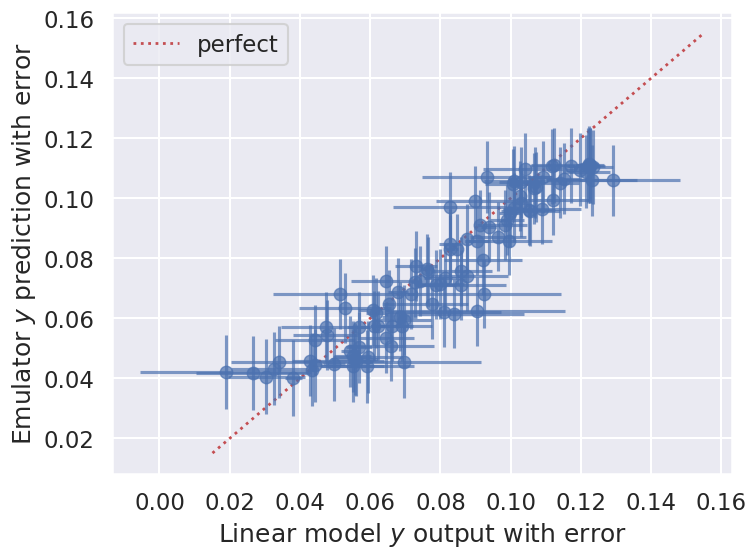

In [11]:
#Plot the emulator prediction vs the linear model output
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plt.xlabel(r'Linear model $y$ output with error')
plt.ylabel(r'Emulator $y$ prediction with error')
model_y_test_min = np.min(model_y_test)
model_y_test_max = np.max(model_y_test)
perfect_line = np.linspace(0.8*model_y_test_min, 1.2*model_y_test_max, 100)
plt.plot(perfect_line, perfect_line, color='r', label='perfect', ls=':', lw=2)
plt.errorbar(model_y_test.flatten(), gp_y_test, xerr=model_dy_test.flatten(), yerr=gp_dy_test.flatten(), 
             ls='None', marker='o', alpha=0.7)

plt.legend()
plt.show()

### How does the performance look? 
There are stricter tests we can use to check if our emulator predictions are biased.

If $\hat{y}(\theta)$ is our emulator prediction for the parameters $\theta$, and $y(\theta)$ is our linear model output, we can define the **residual** $\hat{y}(\theta) - y(\theta)$.

Let's plot the residual as a function of $\theta$:

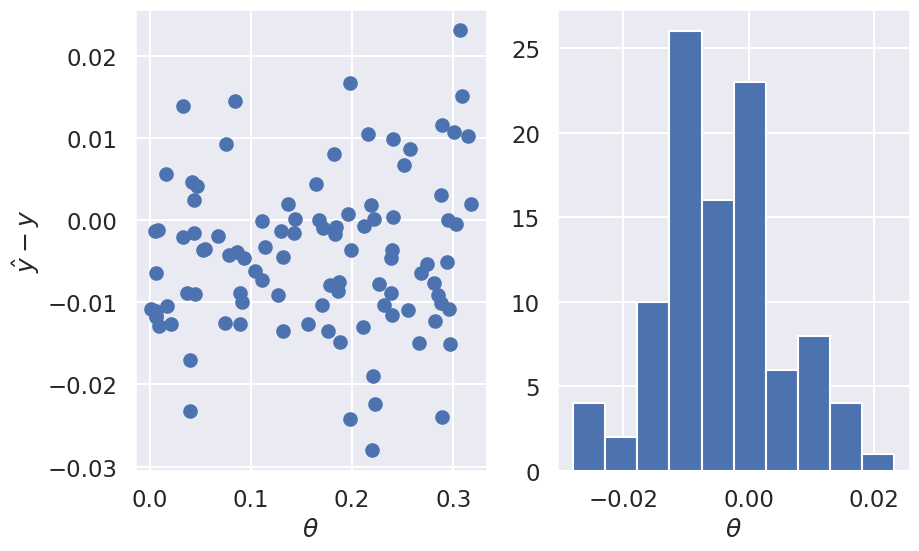

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
model_y_test = model_y_test.reshape(n_test_pts)
res = gp_y_test - model_y_test # calculate the residuals 
axes[0].scatter(model_X_test, res)
axes[0].set_xlabel(r'$\theta$')
axes[0].set_ylabel(r'$\hat{y} - y$')
axes[1].hist(res)
axes[1].set_xlabel(r'$\theta$')
plt.show()

### Does the prediction look biased?

By inspection, does it look like our emulator has significant bias some values of $\theta$?

They are even more illuminating tests one can make, for example Quantile-Quantile plots (https://en.wikipedia.org/wiki/Q–Q_plot). You can explore this on your own.

# Performing Bayesian Inference
Now, we have a fast and accurate emulator that we can trust to compare to data anywhere in the parameter space. 

So let's use our emulator to perform **Bayesian inference**.

Recall, that our **posterior** $p(\theta|D)$ of our parameters $\theta$ given the observed experimental data $D$ is the product of our **prior** belief about the parameters $p(\theta)$ and the **likelihood** $p(D|\theta)$ of observing those experimental data given the true value of the parameters is $\theta$. This is Bayes' Rule:

$$p(\theta|D) \propto p(D|\theta)p(\theta).$$

So, before using experimental data to update our belief about $\theta$, we need to define our prior belief about $\theta$.

### Choosing and plotting our priors

We will define two different priors, so we can examine the effect that our prior has on our posterior.

One prior will be flat between two limits. The other prior will be informed by a belief, before seeing our data, that the parameter $\theta$ is more likely to be a certain value within these limits.

In [13]:
#define two different priors, one more informed than the other

#a flat prior
def log_flat_prior(theta):
    """Flat prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
#a peaked prior
prior_peak = 2. / (4. * np.pi)  # the value of theta we belief most likely, before seeing data
prior_width = 1. / (10. * np.pi) #our uncertainty about this value, before seeing the data
def log_peaked_prior(theta):
    """Peaked (Gaussian) prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return -0.5 * (theta - prior_peak)**2. / prior_width**2. 
    else:
        return -np.inf  # log(0)

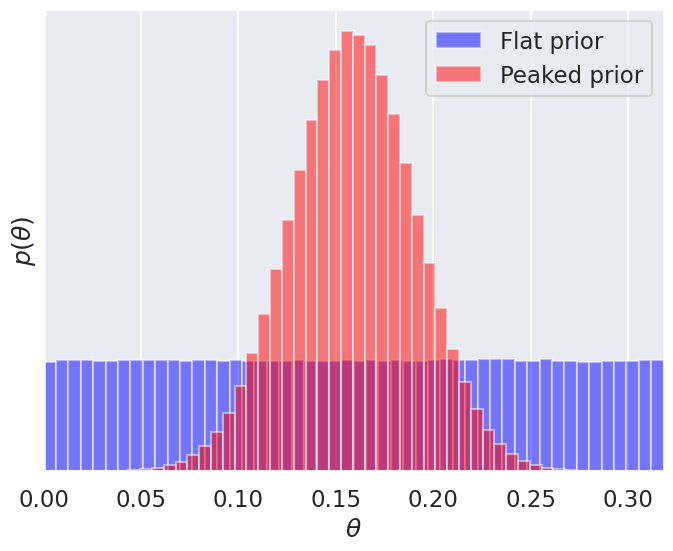

In [14]:
#lets plot our two priors by sampling them, and plotting their histograms
n_samples_prior = int(1e6)
samples_flat_prior = np.random.uniform(theta_min, theta_max, n_samples_prior) 
samples_peaked_prior =  np.random.normal( prior_peak, prior_width, n_samples_prior) 
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plt.hist(samples_flat_prior, label='Flat prior', alpha=0.5, density=True, color='blue', bins=50)
plt.hist(samples_peaked_prior, label='Peaked prior', alpha=0.5, density=True, color='red', bins=50)
plt.xlim([theta_min, theta_max])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.yticks([])
plt.legend()
plt.show()

### Defining our Likelihood
To compare our model predictions with experiment, we need to define our likelihood function.
The likelihood is a model for the conditional probability of observing the data given some true value of the parameters. In this specific example, it models
the conditional probability of observing some experimental value for $y$ given some value of $\theta$.

A commonplace assumption is that the experimental errors follow a multivariate Gaussian distribution. This distribution also maximizes the informational entropy subject to the constraints of being normalizable, having a known mean, and a known variance.
For details see (https://github.com/furnstahl/Physics-8805/blob/master/topics/maximum-entropy/MaxEnt.ipynb). 

The normal likelihood function is probably a good assumption for our problem, because of the nature of the measurement. However, one should consider if this normal likelihood function is appropriate depending on the nature of the specific problem and measurements. 

In [15]:
def log_likelihood(theta, y_exp, dy_exp):
    '''Log-likelihood for data y_exp and uncertainties 
        dy_exp given parameter array theta.'''
    #use our GP emulator to approximate the linear model
    y_pred, dy_pred = emu_predict(theta) # emulation prediction and uncertainty
    sigma2 = dy_pred**2. + dy_exp**2. #total variance, emulation and exp.
    return -0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_pred - y_exp)**2 / sigma2  )

### Exercises:
1. Why does the total uncertainty `sigma2` in the likelihood function have this expression? **Hint: what is the distribution of $y_i$ when we use the emulator vs. when we use the simulator?**

### Defining our Posterior 
The posterior is the product of the prior and likelihood function. 

It follows that the logarithm of the posterior is the sum of the logs of the prior and likelihood.

Since we have two different choices of our prior, we will have two different posteriors.

In [16]:
#posterior using flat prior
def log_posterior_flat_prior(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

#posterior using peaked prior
def log_posterior_peaked_prior(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is Gaussian.'''
    return log_peaked_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

### Inferring the value of $\theta$ using experimental data

Suppose that an experiment measures $y$, and is reported by a mean value and uncertainty.

In [17]:
y_exp = 0.09 # experimental data mean
dy_exp = 0.01 # experimental data uncertainty

Although our current problem is much-simplified by the use of a linear model, in general we will have no analytic expression for our likelihood function. In this case, one needs a set of numerical tools which can approximate the likelihood function. 

In addition, for many problems of interest our parameter space can be high-dimensional, so these methods need to work well for high-dimensional problems.

We approach both of these problems by employing Markov Chain Monte Carlo sampling (http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf).

Specifically, we will use a python implementation called *emcee* (https://emcee.readthedocs.io/en/stable/), which will work well for our simple purposes. There are much more sophisticated algorithms for estimating the posterior today; e.g., parallel-tempered MCMC: https://emcee.readthedocs.io/en/v2.2.1/user/pt/. 

In [18]:
#these are some general settings for the MCMC
ndim = 1  # number of parameters in the model
nwalkers = 20*ndim  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take after the burn-in period finished
nthin = 5 # thinning steps (keep every nthin-th iteration)

# we'll start at random locations within the prior volume
starting_guesses = theta_min + \
                   (theta_max - theta_min) * np.random.rand(nwalkers,ndim)

####Sampling the posterior with a flat prior####
print("Sampling Posterior with Flat Prior...")
print("MCMC sampling using emcee (affine-invariant ensemble sampler) with {0} walkers".format(nwalkers))
sampler_flat_prior = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_flat_prior, args=[y_exp, dy_exp])
# "burn-in" period; save final positions and then reset
state = sampler_flat_prior.run_mcmc(starting_guesses, nburn)
sampler_flat_prior.reset()
# production sampling period
sampler_flat_prior.run_mcmc(state.coords, nsteps, thin=nthin)
# discard burn-in points, perform thinning and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
posterior_flat_prior = sampler_flat_prior.chain.reshape((-1, ndim))

####Sampling the posterior with a peaked prior####
print("Sampling Posterior with Peaked Prior...")
print("MCMC sampling using emcee (affine-invariant ensemble sampler) with {0} walkers".format(nwalkers))
sampler_peaked_prior = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_peaked_prior, args=[y_exp, dy_exp])
# "burn-in" period; save final positions and then reset
state = sampler_peaked_prior.run_mcmc(starting_guesses, nburn)
sampler_peaked_prior.reset()
# production sampling period
sampler_peaked_prior.run_mcmc(state.coords, nsteps, thin=nthin)
# discard burn-in points, perform thinning and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
posterior_peaked_prior = sampler_peaked_prior.chain.reshape((-1, ndim))

Sampling Posterior with Flat Prior...
MCMC sampling using emcee (affine-invariant ensemble sampler) with 20 walkers
Sampling Posterior with Peaked Prior...
MCMC sampling using emcee (affine-invariant ensemble sampler) with 20 walkers


### MCMC Diagnostics

We can plot the traceplots of the posterior samples.

More information on MCMC diagnostics can be found here (and in other modules), feel free to explore them later:
- https://pypi.org/project/arviz/
- https://pymc3-testing.readthedocs.io/en/rtd-docs/api/diagnostics.html
- ...

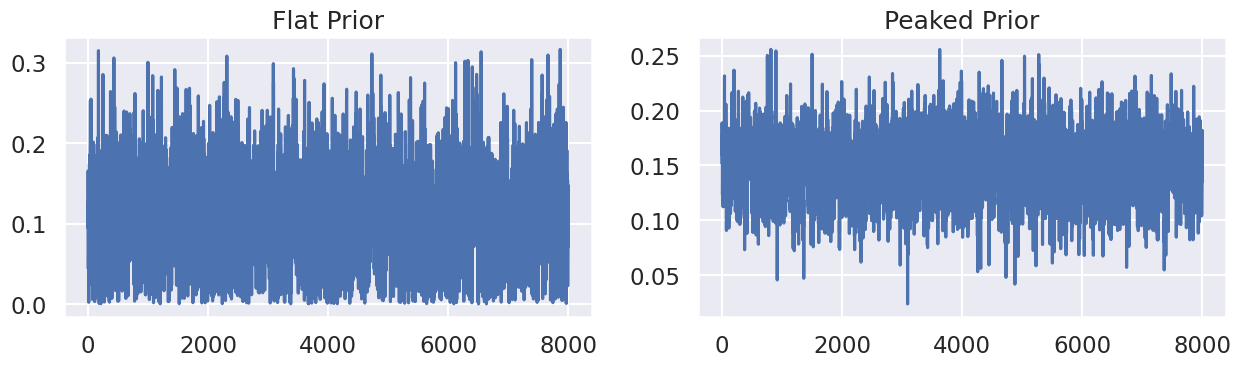

In [19]:
# traceplots
fig = plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.plot(posterior_flat_prior)
plt.title('Flat Prior')
plt.subplot(2,2,2)
plt.plot(posterior_peaked_prior)
plt.title('Peaked Prior')
plt.show()

The traceplots show that the MCMC samplers are mixing well: the samples explore (move around) the parameter space rapidly.

### Plotting our Posteriors

We can plot the samples of our posterior as histograms.

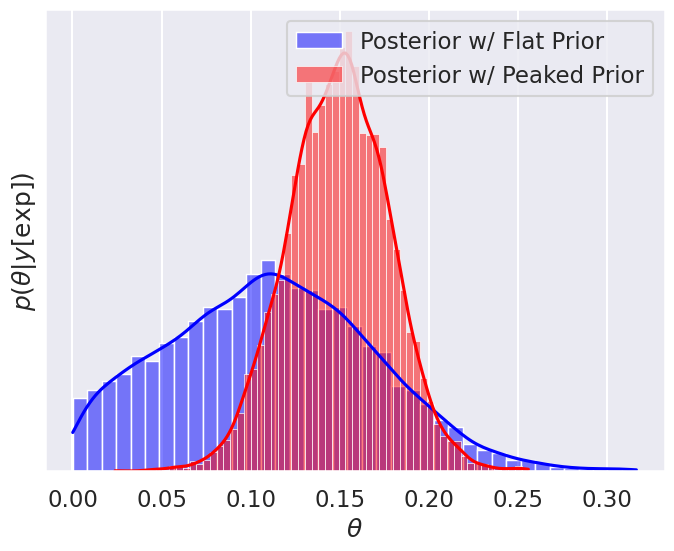

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(posterior_flat_prior.flatten(), kde=True, 
             color='blue', label='Posterior w/ Flat Prior',stat='density')
sns.histplot(posterior_peaked_prior.flatten(), kde=True,
             color='red', label='Posterior w/ Peaked Prior',stat='density')


plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta | y$[exp]$)$')
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

### Exercises

1. What do you notice is different about the two posteriors above (their medians, their uncertainties, etc...)?
2. Try reducing the experimental error on our measurement. What do you expect to happen, and what happens? How does it depend on our emulation (interpolation) uncertainty?
3. Try playing with the parameters which defined the 'peaked' prior (e.g. reducing/increasing its width). What happens?
4. In the case where we use the flat prior, what is the relation between the posterior and the likelihood function?

## We should also plot our posterior predictive distribution

Our posterior in parameter space $p(\theta|D)$ induces a probability distribution in the space of our observables, through our model function.

We can use our emulator to predict the value of the observable $y$ for each sample of the posterior of $\theta$, and plot this distribution.

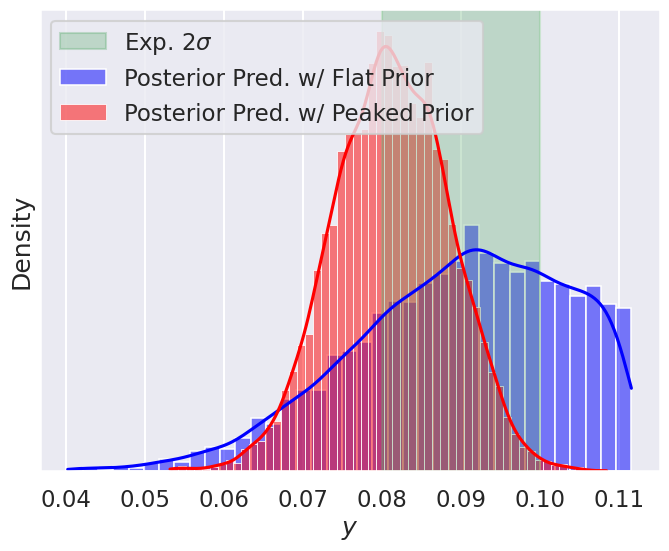

In [21]:
y_posterior_pred_flat, dy_posterior_pred_flat = emu_predict(posterior_flat_prior) #posterior_flat_prior contains posterior samples of $\theta$ using flat prior
y_posterior_pred_peak, dy_posterior_pred_peak = emu_predict(posterior_peaked_prior) #posterior_peaked_prior contains posterior samples of $\theta$ using peaked prior

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(y_posterior_pred_flat, kde=True, 
             color='blue', label='Posterior Pred. w/ Flat Prior',stat='density')
sns.histplot(y_posterior_pred_peak, kde=True, 
             color='red', label='Posterior Pred. w/ Peaked Prior',stat='density')
plt.yticks([])
plt.xlabel(r'$y$')
plt.axvspan(y_exp-dy_exp, y_exp+dy_exp, alpha=0.3, color='g', label=r'Exp. $2\sigma$')
plt.legend(loc='upper left')
plt.show()

### Exercises

1. What do you notice is different about the two posterior predictive distributions above (their medians, their uncertainties, etc...)?
2. What do you conclude about the 'peaked' prior?

## Baseline validation: sampling from Target Posterior distribution:
Finally, we will sample from our target posterior distribution, as a baseline validation for previous results. (see Slides 22-24 in the lecture notes)

The main difference is that, in this section, we will use the simulator (`lin_model`) to compute likelihood directly, instead of using the GP emulator. 

Note that this section is just for validating our posterior distributions generated using the GP emulator. In practice, running the simulator can be computationally expensive and it may be infeasible to generate target posterior distribution using the simulator. (That's also the reason why we introduce emulation.)

### Defining Likelihood using simulator

In [22]:
def log_likelihood_simulator(theta, y_exp, dy_exp):
    '''Log-likelihood for data y_exp and uncertainties 
        dy_exp given parameter array theta.'''
    #use the simulator
    y_sim, dy_sim = lin_model(theta) # output of simulator
    sigma2 = dy_exp**2. # exp. variance
    return -0.5*np.log(2.*np.pi*sigma2) -0.5*( (y_sim - y_exp)**2 / sigma2  )

### Defining Posterior using simulator
The posterior is the product of the prior and likelihood function. 

In [23]:
#posterior using flat prior
def log_posterior_flat_prior_simulator(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_simulator(theta, y_exp, dy_exp)

#posterior using peaked prior
def log_posterior_peaked_prior_simulator(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is Gaussian.'''
    return log_peaked_prior(theta) + log_likelihood_simulator(theta, y_exp, dy_exp)

### Run MCMC

Same set up, just changing the log posterior function.

In [24]:
#these are some general settings for the MCMC
ndim = 1  # number of parameters in the model
nwalkers = 20*ndim  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take after the burn-in period finished
nthin = 5 # thinning steps (keep every nthin-th iteration)

# we'll start at random locations within the prior volume
starting_guesses = theta_min + \
                   (theta_max - theta_min) * np.random.rand(nwalkers,ndim)

####Sampling the posterior with a flat prior####
print("Sampling Posterior with Flat Prior...")
print("MCMC sampling using emcee (affine-invariant ensemble sampler) with {0} walkers".format(nwalkers))
sampler_flat_prior_simulator = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_flat_prior_simulator, args=[y_exp, dy_exp])
# "burn-in" period; save final positions and then reset
state = sampler_flat_prior_simulator.run_mcmc(starting_guesses, nburn)
sampler_flat_prior_simulator.reset()
# production sampling period
sampler_flat_prior_simulator.run_mcmc(state.coords, nsteps, thin=nthin)
# discard burn-in points, perform thinning and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
posterior_flat_prior_simulator = sampler_flat_prior_simulator.chain.reshape((-1, ndim))

####Sampling the posterior with a peaked prior####
print("Sampling Posterior with Peaked Prior...")
print("MCMC sampling using emcee (affine-invariant ensemble sampler) with {0} walkers".format(nwalkers))
sampler_peaked_prior_simulator = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_peaked_prior_simulator, args=[y_exp, dy_exp])
# "burn-in" period; save final positions and then reset
state = sampler_peaked_prior_simulator.run_mcmc(starting_guesses, nburn)
sampler_peaked_prior_simulator.reset()
# production sampling period
sampler_peaked_prior_simulator.run_mcmc(state.coords, nsteps, thin=nthin)
# discard burn-in points, perform thinning and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
posterior_peaked_prior_simulator = sampler_peaked_prior_simulator.chain.reshape((-1, ndim))

Sampling Posterior with Flat Prior...
MCMC sampling using emcee (affine-invariant ensemble sampler) with 20 walkers
Sampling Posterior with Peaked Prior...
MCMC sampling using emcee (affine-invariant ensemble sampler) with 20 walkers


### Plotting the Target Posteriors and compare to Posteriors using Emulator

We can plot the samples of target posterior (using simulator) and our posterior (using emulator) together

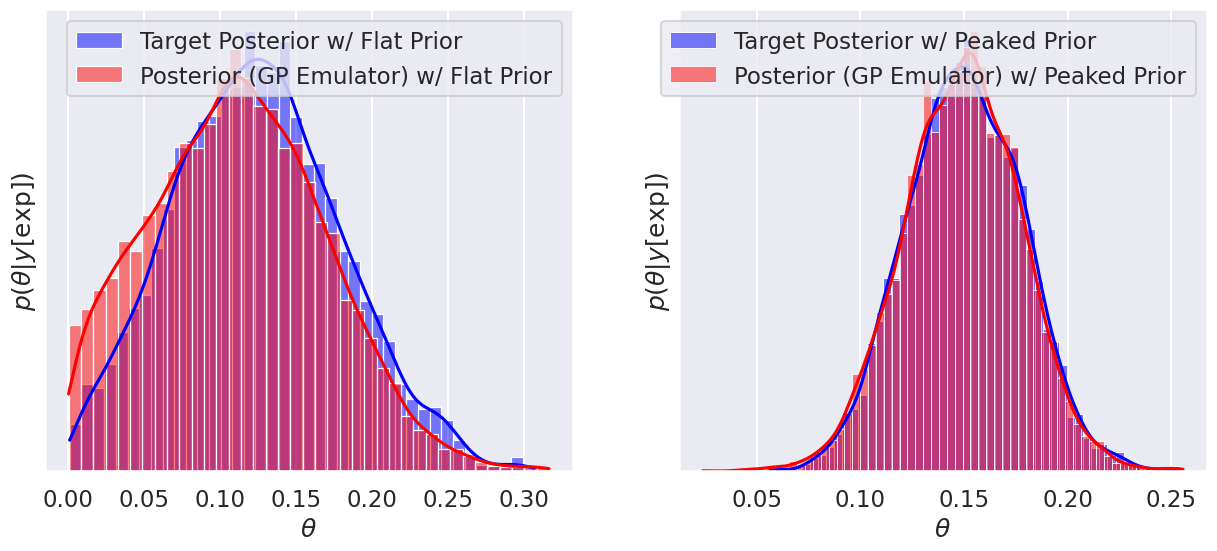

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(posterior_flat_prior_simulator.flatten(), kde=True, 
             color='blue', label='Target Posterior w/ Flat Prior',stat='density')
sns.histplot(posterior_flat_prior.flatten(), kde=True,
             color='red', label='Posterior (GP Emulator) w/ Flat Prior',stat='density')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta | y$[exp]$)$')
plt.yticks([])
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
sns.histplot(posterior_peaked_prior_simulator.flatten(), kde=True, 
             color='blue', label='Target Posterior w/ Peaked Prior',stat='density')
sns.histplot(posterior_peaked_prior.flatten(), kde=True,
             color='red', label='Posterior (GP Emulator) w/ Peaked Prior',stat='density')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta | y$[exp]$)$')
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

### Exercises

1. Do posterior distributions using emulator (our Bayesian inference results) agree with the target posterior distributions using simulator (baseline validations)?

# We're finished!

Now you can try applying some of these ideas to your own research. 